# Table of Contents
 <p>

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
car = cv2.cvtColor(cv2.imread("../../vehicles_smallset/cars1/1.jpeg"), cv2.COLOR_BGR2RGB)
noncar = cv2.cvtColor(cv2.imread("../../non-vehicles_smallset/notcars1/extra810.jpeg"), cv2.COLOR_BGR2RGB)

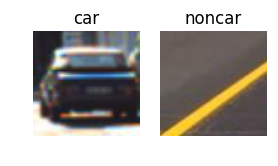

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(3, 10))
axes[0].imshow(car); axes[0].set_title("car")
axes[1].imshow(noncar); axes[1].set_title("noncar")
[axe.axis('off') for axe in axes]
plt.savefig("./example_images/car_noncar.jpg", dpi=10)
plt.show()

In [5]:
import matplotlib.image as mpimg
from skimage import io
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC # for rbf
from sklearn.metrics import accuracy_score

In [6]:
def cal_hog_feature(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Extract HOG feature from one color channel"""
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
    return features

def extract_hog_features(image, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, hog_color="RGB"):
    """Extract HOG features from colorspace you specify"""
    if hog_color != 'RGB':
        if hog_color == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif hog_color == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif hog_color == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif hog_color == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif hog_color == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.extend(cal_hog_feature(feature_image[:,:,channel],
                            orient, pix_per_cell, cell_per_block,
                            vis=viz, feature_vec=feature_vec))

def extract_features(images, hog_color='RGB', spatial_color="LUV", hist_color="HLS", spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract features from HOG, color binning, and histogram of color space.
       You could choose features you wanna use.

       # Returns:
           features(ndarray): extracted features (1-dimensional array)
    """
    features = []
    for image in images:
        file_features = []
        if spatial_feat == True:
            spatial_features = bin_spatial(image, size=spatial_size, color=spatial_color)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(image, nbins=hist_bins, color=hist_color)
            file_features.append(hist_features)
        if hog_feat == True:
            hog_features = extract_hog_features(image, orient, pix_per_cell, cell_per_block, hog_color=hog_color)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return np.array(features)

def bin_spatial(image, size=(32, 32), color="RGB"):
    """binning image of specified color space"""
    if color != 'RGB':
        if color == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return cv2.resize(feature_image, size).ravel()

def color_hist(image, nbins=32, bins_range=(0, 256), color="RGB"):
    """convert RGB Image to specified color space histogram"""
    if color != 'RGB':
        if color == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    channel1_hist = np.histogram(feature_image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(feature_image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(feature_image[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [7]:
def input_datasets(datasets, shape=(64, 64, 3)):
    """Input images from pathes of car and non-car.
       For adjust brightness, left-right balance, I apply data augmentation
       Apply Flip and Brightness conversion to GTI_Left and GTI_Right

       # Args:
           datasets(dic): pathes of datasets "car" and "non-car"
           shape(tuple) : shape of input images

       # Returns:
           input_images(ndarray): all images of datasets(4 dimension)
           Y (ndarray)          : all labels of datasets(1 (car) or 0 (non-car))
    """
    left_true = glob.glob("./vehicles/GTI_Left/*.png")
    len_left_true = len(left_true)
    right_true = glob.glob("./vehicles/GTI_Right/*.png")
    len_right_true = len(right_true)
    input_images = np.zeros((datasets["car"].shape[0] + datasets["noncar"].shape[0],
        shape[0], shape[1], shape[2]), dtype=np.uint8)
    input_images[:datasets["car"].shape[0]] = [io.imread(path) for path in datasets["car"]]
    input_images[datasets["car"].shape[0]:] = [io.imread(path) for path in datasets["noncar"]]

    augmented_images = np.zeros((len_left_true*2 + len_right_true*2,
        shape[0], shape[1], shape[2]), dtype=np.uint8)
    augmented_images[:len_left_true] = [augment_brightness_image(io.imread(path)) for path in left_true]
    augmented_images[len_left_true:len_left_true*2] = [cv2.flip(augment_brightness_image(io.imread(path), bright=1.1), 1) for path in left_true]
    augmented_images[2*len_left_true:2*len_left_true+len_right_true] = [augment_brightness_image(io.imread(path)) for path in right_true]
    augmented_images[2*len_left_true+len_right_true:] = [cv2.flip(augment_brightness_image(io.imread(path), bright=1.1), 1) for path in right_true]
    input_images = np.vstack((input_images, augmented_images))
    Y = np.hstack((np.ones((datasets["car"].shape[0])), np.zeros(datasets["noncar"].shape[0])))
    Y = np.hstack((Y, np.ones((len_left_true*2 + len_right_true*2))))
    return input_images, Y

def main():
#     datasets = make_datasets("./vehicles/*", "./non-vehicles/*")
#     X, Y = input_datasets(datasets)
    car = cv2.cvtColor(cv2.imread("../../vehicles_smallset/cars1/1.jpeg"), cv2.COLOR_BGR2RGB)
    noncar = cv2.cvtColor(cv2.imread("../../non-vehicles_smallset/notcars1/extra810.jpeg"), cv2.COLOR_BGR2RGB)
    X = extract_features(X, hog_color="YCrCb", hog_channel="ALL", hist_color="YCrCb", spatial_size=(16, 16),
        spatial_color="YCrCb", orient=18, cell_per_block=3, spatial_feat=True)

if __name__ == "__main__":
    main()

UnboundLocalError: local variable 'X' referenced before assignment

In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [9]:
_, hog_car_0 = get_hog_features(car[:, :, 0], 18, 8, 3, vis=True)
_, hog_car_1 = get_hog_features(car[:, :, 1], 18, 8, 3, vis=True)
_, hog_car_2 = get_hog_features(car[:, :, 2], 18, 8, 3, vis=True)
_, hog_noncar_0 = get_hog_features(noncar[:, :, 0], 18, 8, 3, vis=True)
_, hog_noncar_1 = get_hog_features(noncar[:, :, 1], 18, 8, 3, vis=True)
_, hog_noncar_2 = get_hog_features(noncar[:, :, 2], 18, 8, 3, vis=True)

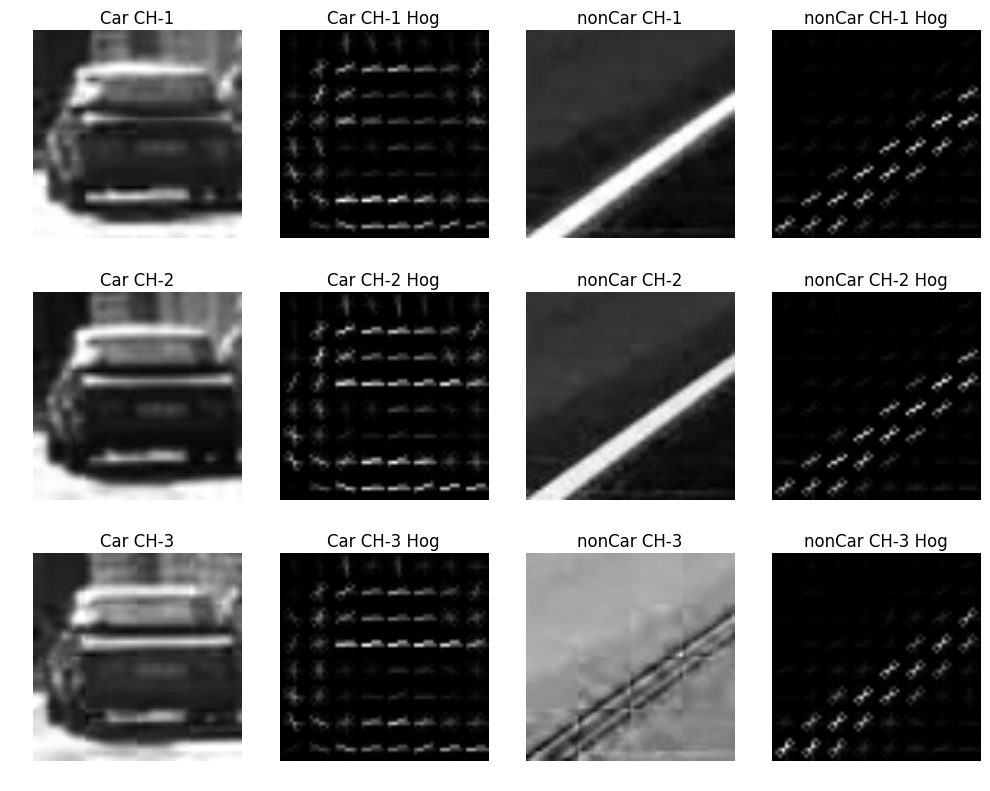

In [37]:
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes[0, 0].imshow(car[:, :, 0]); axes[0, 0].set_title("Car CH-1")
axes[0, 1].imshow(hog_car_0); axes[0, 1].set_title("Car CH-1 Hog")
axes[1, 0].imshow(car[:, :, 1]); axes[1, 0].set_title("Car CH-2")
axes[1, 1].imshow(hog_car_1); axes[1, 1].set_title("Car CH-2 Hog")
axes[2, 0].imshow(car[:, :, 2]); axes[2, 0].set_title("Car CH-3")
axes[2, 1].imshow(hog_car_2); axes[2, 1].set_title("Car CH-3 Hog")

axes[0, 2].imshow(noncar[:, :, 0]); axes[0, 2].set_title("nonCar CH-1")
axes[0, 3].imshow(hog_noncar_0); axes[0, 3].set_title("nonCar CH-1 Hog")
axes[1, 2].imshow(noncar[:, :, 1]); axes[1, 2].set_title("nonCar CH-2")
axes[1, 3].imshow(hog_noncar_1); axes[1, 3].set_title("nonCar CH-2 Hog")
axes[2, 2].imshow(noncar[:, :, 2]); axes[2, 2].set_title("nonCar CH-3")
axes[2, 3].imshow(hog_noncar_2); axes[2, 3].set_title("nonCar CH-3 Hog")
[ax.axis("off") for axe in axes for ax in axe]
fig.tight_layout()
plt.gray()
plt.savefig("./example_images/features.jpg", dpi=50)
plt.show()